In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.tsa as tsa

from pandas import DatetimeIndex
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# https://github.com/robjhyndman/fma/blob/master/R/bricksq.R
# Australian quarterly clay brick production: 1956--1994.
data = np.array([189, 204, 208, 197, 187, 214, 227, 223, 199,
229, 249, 234, 208, 253, 267, 255, 242, 268, 290, 277, 241, 253,
265, 236, 229, 265, 275, 258, 231, 263, 308, 313, 293, 328, 349,
340, 309, 349, 366, 340, 302, 350, 362, 337, 326, 358, 359, 357,
341, 380, 404, 409, 383, 417, 454,428, 386, 428, 434, 417, 385,
433, 453, 436, 399, 461, 476, 477, 452, 461, 534, 516, 478, 526,
518, 417, 340, 437, 459, 449, 424, 501, 540, 533, 457, 513, 522,
478, 421, 487, 470, 482, 458, 526, 573, 563, 513, 551, 589, 564,
519, 581, 581, 578, 500, 560, 512, 412, 303, 409, 420, 413, 400,
469, 482, 484, 447, 507, 533, 503, 443, 503, 505, 443, 415, 485,
495, 458, 427, 519, 555, 539, 511, 572, 570, 526, 472, 524, 497,
460, 373, 436, 424, 430, 387, 413, 451, 420, 394, 462, 476, 443,
421, 472, 494])

# First we plot the data to see what it looks like

In [2]:
plt.figure(figsize=(14,5))
plt.plot(data)
plt.show()

In [3]:


def tsplot(y, lags=15):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # layout
    fig = plt.figure(figsize=(14, 6))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    # ts plot
    y.plot(ax=ts_ax)
    ts_ax.set_title('Time series');
    
    # acf, pacf
    plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5) 


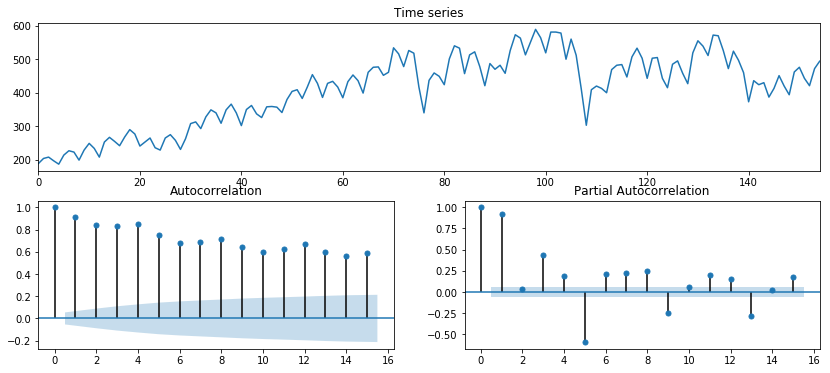

In [4]:
tsplot(data)

# Trend and seasonality is visible in the plot above, we can remove the trend using seasonal decomposition

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Suma kvadrátů reziduí ACF: 1.2224280356838677


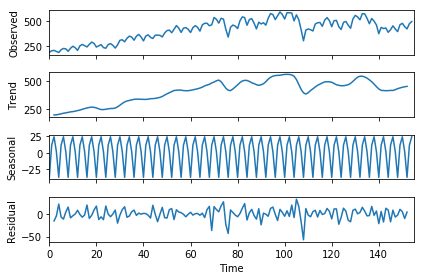

In [5]:


result = seasonal_decompose(data, freq=4, model='additive')
resid_acf = acf(result.resid, nlags=10, missing='drop')
sum_of_squares_resid_acf = np.sum(resid_acf**2)
print('Suma kvadrátů reziduí ACF:', sum_of_squares_resid_acf)

result.plot()
plt.show()

In [6]:


result_mul = seasonal_decompose(data, freq=4, model='multiplicative')
resid_acf = acf(result_mul.resid, nlags=10, missing='drop')
sum_of_squares_resid_acf = np.sum(resid_acf**2)
print('Suma kvadrátů reziduí ACF:', sum_of_squares_resid_acf)

result_mul.plot()
plt.show()

Suma kvadrátů reziduí ACF: 1.145228307246676


# Sum of square residuals hints that multiplicative model could a better choice for decomposition

In [7]:
detrended = data - result_mul.trend
dtr = detrended[np.logical_not(np.isnan(detrended))]

tsplot(dtr)


## We will use pandas to create datetime indexed dataframe 7
first datapoint is lost with detrending

In [8]:

kok =pd.date_range(start='4/4/1956', periods=151, freq='Q')
df = pd.DataFrame(index=kok,data=dtr, columns=['prod'])


# Models

Now lets try three different models *ARMA*, *ARIMA* and *SARIMAX*, we will always try find the best orders by optimizing over *AIC*

### First we can tre using an *ARMA* model

Starting with order selection

In [9]:



tsa.stattools.arma_order_select_ic(df, trend='c', ic='aic', max_ar=3)

/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

{'aic':              0            1            2
 0  1421.570735  1349.568487  1329.063547
 1  1422.427708  1347.755181  1329.331939
 2  1305.441974  1283.482573  1254.418057
 3  1257.562349  1220.061080  1221.890790, 'aic_min_order': (3, 1)}

In [10]:
arma = ARMA(df, order=(3,1)).fit(trend='c')
print(arma.summary())

                              ARMA Model Results                              
Dep. Variable:                   prod   No. Observations:                  151
Model:                     ARMA(3, 1)   Log Likelihood                -604.031
Method:                       css-mle   S.D. of innovations             13.042
Date:                Sun, 15 Dec 2019   AIC                           1220.061
Time:                        16:24:47   BIC                           1238.165
Sample:                    06-30-1956   HQIC                          1227.416
                         - 12-31-1993                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0078      0.526     -0.015      0.988      -1.039       1.024
ar.L1.prod    -1.0073      0.052    -19.368      0.000      -1.109      -0.905
ar.L2.prod    -0.8903      0.054    -16.339      0.0

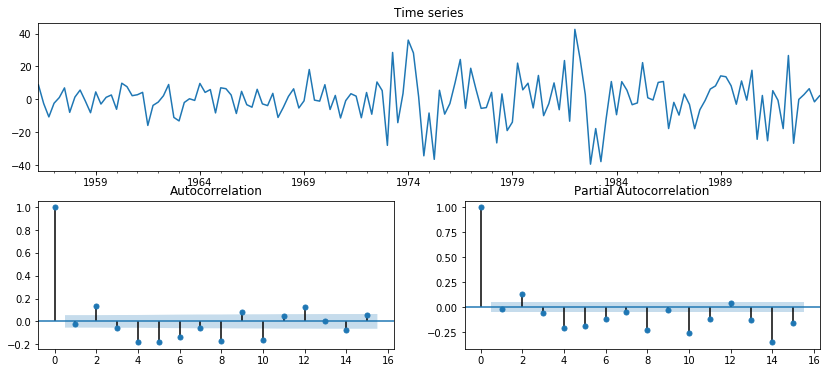

In [11]:
tsplot(arma.resid)
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


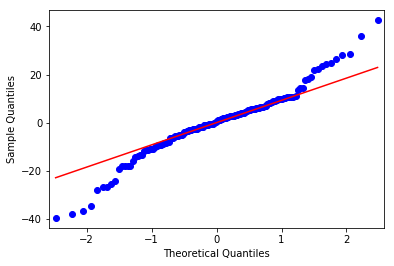

In [12]:
from statsmodels.api import qqplot

qqplot(arma.resid, line='q')
plt.show()

In [13]:
plt.hist(arma.resid)
plt.show()

### Predictions

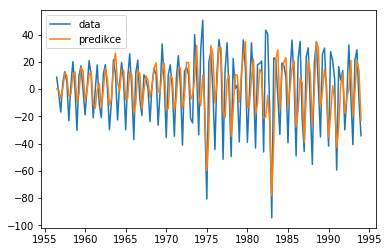

In [14]:
preds = arma.predict(dynamic=False)
plt.plot(df, label='data')
plt.plot(np.cumsum(preds), label='predikce')
plt.legend()

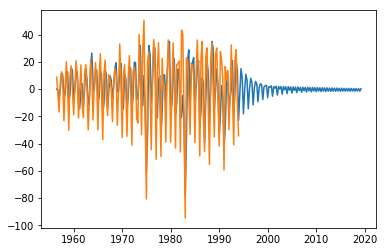

In [15]:
fcast_steps = 100
ndat = len(dtr)
fcast = arma.predict(start=0, end=ndat+fcast_steps)
plt.plot(np.cumsum(fcast))
plt.plot(df)

## ARIMA model



In [16]:

import itertools
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
print('Examples of parameter for ARIMA...')
print('ARIMA: {}'.format(pdq[1]))
print('ARIMA: {}'.format(pdq[1]))

min_aic = None
for param in pdq:
    try:
        if param[0] == 0 and param[2] == 0:
            continue
        mod = ARIMA(df, param)
        results = mod.fit(trend='nc')
        if not min_aic:
            min_aic = results.aic
            print('ARIMA{}12 - AIC:{}'.format(param,results.aic))
        elif min_aic > results.aic:
            best_param = param
            min_aic = results.aic
            print('NEW BEST')
            print('ARIMA{} - AIC:{}'.format(param,results.aic))
        else:
            #print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
            pass
    except:
        pass
            
print('Best param setting seems to be ARIMA{} - AIC:{}'.format(best_param,min_aic))


Examples of parameter for ARIMA...
ARIMA: (0, 0, 1)
ARIMA: (0, 0, 1)
ARIMA(0, 0, 1)12 - AIC:1348.1783604681866
NEW BEST
ARIMA(0, 0, 2) - AIC:1327.3167822273936
NEW BEST
ARIMA(1, 0, 3) - AIC:1300.2248232855081
NEW BEST
ARIMA(2, 0, 1) - AIC:1281.4856303399201


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NEW BEST
ARIMA(2, 0, 2) - AIC:1248.1243418374725


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:649: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: divide by zero encountered in arctanh
  invarcoefs = 2*np.arctanh(params)


NEW BEST
ARIMA(3, 0, 1) - AIC:1218.061302814318


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best param setting seems to be ARIMA(3, 0, 1) - AIC:1218.061302814318


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [17]:
arima = ARIMA(df, (3,0,1)).fit(trend='nc')
print(arima.summary())

                              ARMA Model Results                              
Dep. Variable:                   prod   No. Observations:                  151
Model:                     ARMA(3, 1)   Log Likelihood                -604.031
Method:                       css-mle   S.D. of innovations             13.042
Date:                Sun, 15 Dec 2019   AIC                           1218.061
Time:                        16:24:56   BIC                           1233.148
Sample:                    06-30-1956   HQIC                          1224.190
                         - 12-31-1993                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.prod    -1.0073      0.052    -19.370      0.000      -1.109      -0.905
ar.L2.prod    -0.8903      0.054    -16.339      0.000      -0.997      -0.784
ar.L3.prod    -0.8611      0.039    -22.319      0.0

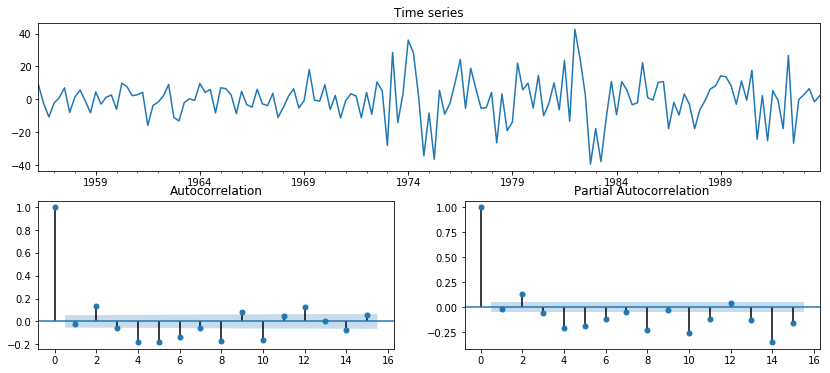

In [18]:
tsplot(arima.resid)
plt.show()

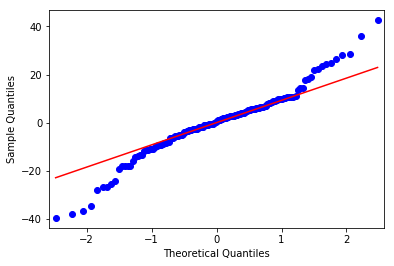

In [19]:
qqplot(arima.resid, line='q')
plt.show()

In [20]:
plt.hist(arma.resid)
plt.show()

In [21]:
preds = arima.predict(dynamic=False)
plt.plot(df, label='data')
plt.plot(np.cumsum(preds), label='predikce')
plt.legend()

In [22]:
fcast_steps = 100
ndat = len(df)
fcast = arima.predict(start=1, end=ndat+fcast_steps)
plt.plot(np.cumsum(fcast))
plt.plot(df)

## SARIMAX model
### This takes a while feel free to uncomment a run it yourself, results is printed below
The AIC (Akaike information criterion) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. The low AIC value the better. 

In [23]:
'''
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

min_aic = None
for param in pdq:
    for param_seasonal in seasonal_pdq:

        mod = sm.tsa.statespace.SARIMAX(dtr,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        if not min_aic:
            min_aic = results.aic
            print('ARIMA{}x{}- AIC:{}'.format(param,param_seasonal,results.aic))
        elif min_aic > results.aic:
            best_param = param
            best_param_s =  param_seasonal
            min_aic = results.aic
            print('NEW BEST')
            print('ARIMA{}x{}- AIC:{}'.format(param,param_seasonal,results.aic))
        else:
            #print('ARIMA{}x{}- AIC:{}'.format(param,param_seasonal,results.aic))
            pass

            
print('Best param setting seems to be ARIMA{}x{}- AIC:{}'.format(best_param,best_param_s,min_aic))
'''
print('Best param setting seems to be ARIMA(1, 0, 2)x(0, 2, 2, 4)- AIC:1042.8553468729774')

Best param setting seems to be ARIMA(1, 0, 2)x(0, 2, 2, 4)- AIC:1042.8553468729774


In [24]:
sarimax = SARIMAX(df, order=(1,0,2), seasonal_order=(0,2,2,4), enforce_stationarity=False,enforce_invertibility=False)
srm_fit = sarimax.fit()
print(srm_fit.summary())

                                 Statespace Model Results                                
Dep. Variable:                              prod   No. Observations:                  151
Model:             SARIMAX(1, 0, 2)x(0, 2, 2, 4)   Log Likelihood                -515.428
Date:                           Sun, 15 Dec 2019   AIC                           1042.855
Time:                                   16:24:59   BIC                           1060.152
Sample:                               06-30-1956   HQIC                          1049.884
                                    - 12-31-1993                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3299      0.125      2.637      0.008       0.085       0.575
ma.L1         -0.6634    218.991     -0.003

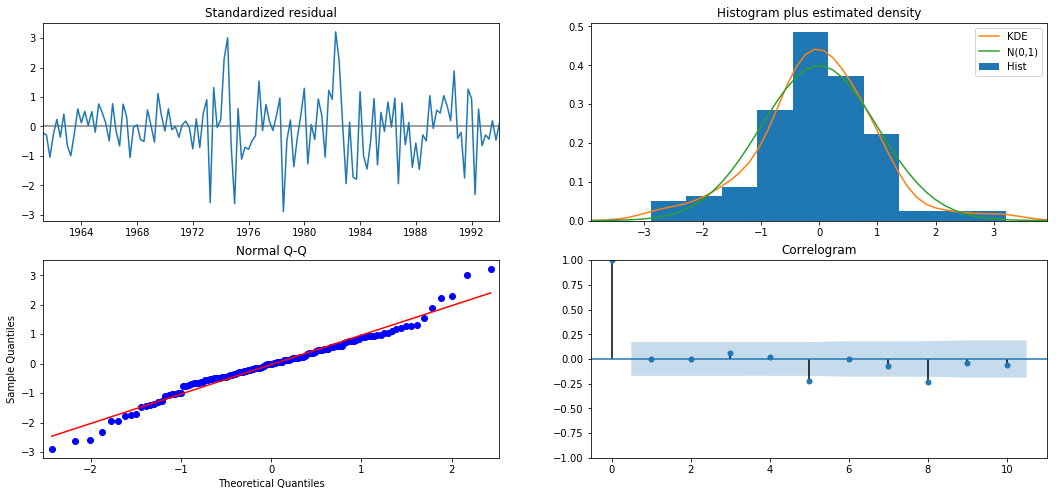

In [25]:
srm_fit.plot_diagnostics(figsize=(18, 8))
plt.show()

<Figure size 1080x216 with 0 Axes>

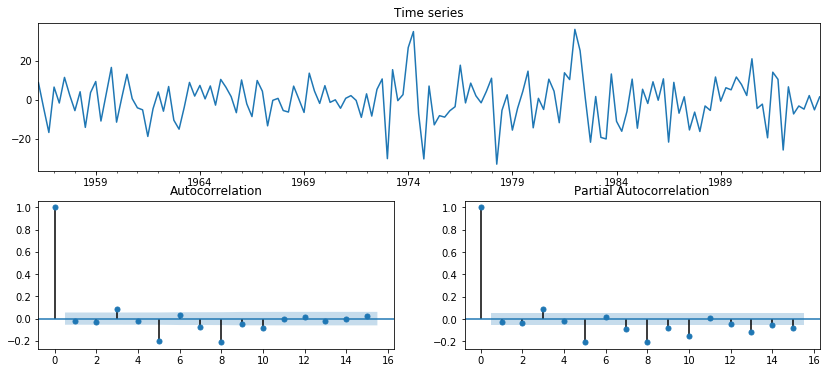

In [26]:
plt.figure(figsize=(15,3))
tsplot(srm_fit.resid)
plt.show()

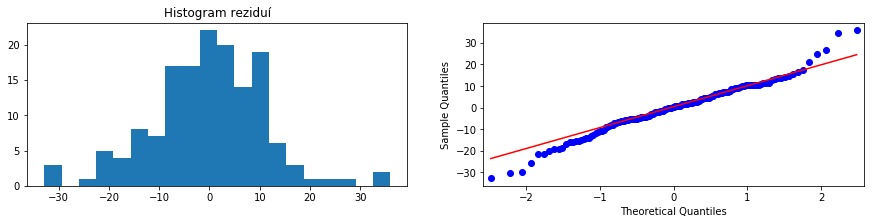

In [27]:
plt.figure(figsize=(15,3))
ax = plt.subplot(1,2,1)
plt.hist(srm_fit.resid, bins=20)
plt.title('Histogram reziduí')
ax = plt.subplot(1,2,2)
qqplot(srm_fit.resid, line='q', ax=ax)
plt.show()

In [28]:
nsteps = 100
forecast = srm_fit.get_forecast(steps=nsteps)
plt.figure(figsize=(15,3))
plt.plot(np.arange(df.size), df, label='observed')
plt.plot(np.arange(df.size, df.size+forecast.predicted_mean.size), 
         forecast.predicted_mean, 'r', label='predicted')
plt.fill_between(np.arange(df.size, df.size+forecast.predicted_mean.size), 
                 forecast.summary_frame()['mean_ci_lower'],
                 forecast.summary_frame()['mean_ci_upper'],
                 color='lightgray')
plt.legend()
plt.xlabel('quarter')
plt.ylabel('bricks')
plt.show()

In [29]:
pred = srm_fit.get_prediction(start=pd.to_datetime('1984-12-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['1956':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Quart')
ax.set_ylabel('bricks')
plt.legend()
plt.show()

# Results

Comparing AIC we can see that the ARIMA is the same as ARMA and SARIMAX is the best, yay